In [2]:
from einops import rearrange, repeat
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import trange

from drumblender.utils.modal_analysis import CQTModalAnalysis
from drumblender.synths import ModalSynthFreqs

# Auxiliary functions extracted from nbdev
from aux_functions import load_audio_torch, stft_loss

/homes/fsc01/.conda/envs/drumblender/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modal synth approximation
Finetuning amplitudes and phases using complex STFT loss

## Kick Drum

Load a drum sound as the target, sound from : https://www.ableton.com/en/packs/drum-booth/

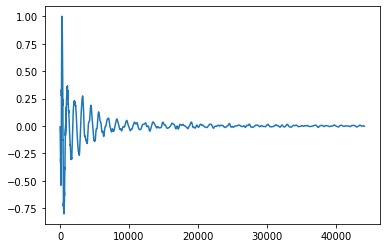

In [3]:
kick, sr = load_audio_torch("audio/db_kick_1.wav")

# Pad to 1 second
if kick.shape[1] < sr:
    kick = torch.nn.functional.pad(kick, (0, sr - kick.shape[1]))

plt.plot(kick[0].numpy())
ipd.Audio(kick[0].numpy(), rate=sr)

### Constant-Q Spectrogram

In [4]:
hop_length = 64
fmin = 20.0
n_bins = 96
bins_per_octave = 12
cqt_analysis = CQTModalAnalysis(
    sample_rate=sr,
    hop_length=hop_length,
    fmin=fmin,
    n_bins=n_bins,
    bins_per_octave=bins_per_octave,
    num_modes=30,
    pad_mode="reflect",
)

CQT kernels created, time used = 0.1497 seconds


## Resynthesis

torch.Size([1, 30, 690]) torch.Size([1, 30, 690]) torch.Size([1, 30, 690])
torch.Size([1, 44096]) torch.Size([1, 44100])


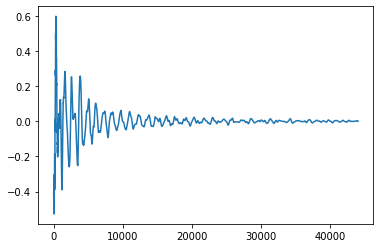

In [5]:
freqs, amps, phases = cqt_analysis(kick)
print(freqs.shape, amps.shape, phases.shape)

freq_env = 2 * np.pi * freqs / sr
phase_start = phases[:,:,0]

modal_synth = ModalSynthFreqs(window_size=hop_length*2)


modal_out = modal_synth((amps,freq_env,phase_start))
plt.plot(modal_out[0].numpy())
ipd.Audio(modal_out[0].numpy(), rate=sr)
print(modal_out.shape,kick.shape)

## Fine tuning modal amplitudes and phases

In [6]:
class FineTuneDrum:
    def __init__(self, opt_synth, iters=2000, lr=1e-3, t_weight=1.0):
        self.synth = opt_synth
        self.iters = iters
        self.lr = lr
        self.opt = torch.optim.Adam(self.synth.parameters(), lr=self.lr)
        self.loss_log = []
        self.t_weight = t_weight

    def __call__(self, x):
        t = trange(self.iters, desc="Error", leave=True)
        for i in t:
            # Compute the sinusoid with updated paraetmers
            x_hat = self.synth()

            # Calculate a Multi-resolution STFT loss with a complex loss
            err1 = stft_loss(x, x_hat, window_size=128, hop_size=64)
            err2 = stft_loss(x, x_hat, window_size=128, hop_size=64, complex=True)
            err3 = stft_loss(x, x_hat, window_size=512, hop_size=256)
            err4 = stft_loss(x, x_hat, window_size=1024, hop_size=512)
            err = err1 + err2 * self.t_weight + err3 + err4

            self.loss_log.append(err.detach().numpy())

            # Update tqdm description
            t.set_description(f"Error: {err.detach().numpy()}")

            # Optimize
            self.opt.zero_grad()
            err.backward()
            self.opt.step()

In [7]:
class ModalTunerFreqs(nn.Module):
    def __init__(self,synth : ModalSynthFreqs,
                 freqs : torch.Tensor,
                 amps : torch.Tensor,
                 phases : torch.Tensor,
                 sr : int):
        super().__init__()
        self.synth = synth
        #self.freqs = self.register_buffer('modal freqs',freqs)
        self.freqs = freqs
        self.amps = nn.Parameter(amps,requires_grad=True)
        self.phases = nn.Parameter(phases,requires_grad=True)
        self.sr = sr
    
    def forward(self):
        freq_env = 2 * np.pi * self.freqs / self.sr
        return self.synth(
            (self.amps,freq_env,self.phases)
        )

In [8]:
tuner = ModalTunerFreqs(modal_synth,freqs,amps,phase_start,sr)
# | eval: false
optimize = FineTuneDrum(tuner, iters=50, lr=1e-3)
optimize(kick)

Error: 0.00044792552944272757: 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


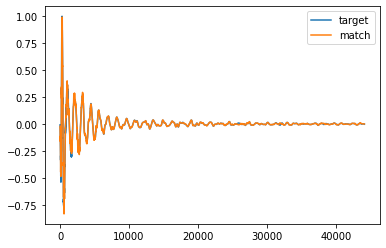

In [9]:
x = tuner()

plt.plot(kick[0].detach().numpy(), label="target")
plt.plot(x[0].detach().numpy(), label="match")
plt.legend()
plt.show()

ipd.display(ipd.Audio(x[0].detach().numpy(), rate=sr))
ipd.display(ipd.Audio(kick[0].detach().numpy(), rate=sr))